### `---------------Mandatory Information to fill------------`

### Group ID: 43
### Group Members Name with Student ID:
1. SUBHRANSU MISHRA 2023AC05489
2. JAWAHARLAL RAJAN S 2023AC05504
3. SHAILESH KUMAR SINGH 2023AC05475
4. LAKSHMISRINIVAS PERAKAM 2023AC05540


`-------------------Write your remarks (if any) that you want should get consider at the time of evaluation---------------`

Remarks: ##Add here

# Background

In the world of online streaming, user satisfaction and engagement are critical metrics for the success of a movie recommendation system. A well-designed recommendation algorithm can significantly enhance user experience by suggesting movies that align with their preferences, leading to higher platform retention and usage. Recommendation systems face the challenge of balancing exploration (discovering new movies) with exploitation (recommending known favourites) to maximize user satisfaction over time.


# Scenario

Imagine a leading online movie streaming platform, TrendMovie Inc., that aims to become the go-to destination for personalized movie recommendations. The platform features a vast collection of movies catering to diverse audiences. TrendMovie Inc. wants to optimize its recommendation strategy to deliver maximum user satisfaction while maintaining a high level of engagement. Each movie recommendation is treated as an interaction with the user, and their feedback is used to refine the recommendation strategy dynamically.


# Objective

Your objective is to design and implement a recommendation system using Multi-Armed Bandit (MAB) algorithms to maximize cumulative user satisfaction. The system should dynamically allocate recommendations by learning user preferences in real-time, striking the right balance between exploration and exploitation.


# Dataset

The dataset contains user ratings for a variety of movies. Key columns in the dataset include:
*   **User ID:** A unique identifier for each user.
*   **Movie ID:** A unique identifier for each.
*   **Rating:** A score provided by the user for a movie (on a scale of 1 to 5).
*   **Timestamp:** The time when the rating was given (optional for this assignment).

***Link for accessing dataset:***
https://drive.google.com/file/d/1gfobhqlVCw8Oo52JCiYpEBGhG5k7cWBr/view?usp=drive_link


# Environment Details

**Arms:** Each movie represents an "arm" in the MAB framework. The probability of a movie being liked by a user is initially unknown and will be estimated based on user feedback during the interactions.
For example:

Arm 1: Movie A

Arm 2: Movie B

Arm 3: Movie C

... and so on, for all movies in the dataset.

**Reward Function:**
The reward function is defined based on user ratings:

***Reward = 1:*** The user rates the movie high star (e.g., 4 or 5 stars).

***Reward = 0:*** The user rates the movie low star (e.g., 1, 2, or 3 stars).


**Assumptions:**

Run simulations for 1000 iterations for each policy


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [12]:
!pip install gym pandas

In [13]:
import random
import numpy as np
import pandas as pd
import gym

# Constants
no_of_iterations = 1000

# Initialize value function and policy

# Load Dataset (0.5M)

In [14]:
# Code for Dataset loading and print dataset statistics
#-----write your code below this line---------


# Data Exploration

import pandas as pd

# Load the dataset
dataset = pd.read_csv("TrendMovie.csv")

# Display basic information about the dataset
print("Dataset Info:")
dataset.info()

print("Total Movie count:")
print(len(dataset['movieId'].unique()))

# Display the first few rows of the dataset
print("\nDataset Preview:")
print(dataset.head())

# Check for missing values
print("\nMissing Values:")
print(dataset.isnull().sum())

# Summary statistics of the ratings
print("\nSummary Statistics:")
print(dataset["rating"].describe())

# Preprocessing

# Convert timestamp to a readable format
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], unit="s")

# Sort by user and timestamp for consistent processing
dataset = dataset.sort_values(by=["userId", "timestamp"]).reset_index(drop=True)

print("\nProcessed Dataset Preview:")
print(dataset.head())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
Total Movie count:
9724

Dataset Preview:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Missing Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Summary Statistics:
count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, d

# Design a Movie Environment (0.5M)

In [15]:
import random
import pandas as pd
import gym
import math

# Define the Movie Recommendation Environment
class MovieRecommendationEnv(gym.Env):
    def __init__(self, data):
        """
        Initialize the environment.

        Parameters:
        - data: DataFrame containing user ratings with columns: 'userId', 'movieId', 'rating'.
        """
        self.data = data
        self.movies = data['movieId'].unique()  # Unique movie IDs
        self.reset()  # Initialize the state

    def step(self, action):
        """
        Simulate a user's interaction with a selected movie (arm).

        Parameters:
        - action: The selected movie ID (arm).

        Returns:
        - state: Updated state with rewards for each movie.
        - reward: 1 if liked, 0 otherwise.
        - done: Always False, as this is a continuous environment.
        - debug: None for now (can be extended for additional info).
        """
        # Filter ratings for the selected movie
        movie_ratings = self.data[self.data['movieId'] == action]['rating']
        
        # Use the average rating for the movie
        if not movie_ratings.empty:
            avg_rating = movie_ratings.mean()
            reward = 1 if avg_rating >= 4.0 else 0  # High rating gives a reward of 1
        else:
            reward = 0  # Default to 0 if no ratings are available

        self.state[action].append(reward)  # Update state with reward
        done = False
        debug = None
        return self.state, reward, done, debug

    def reset(self):
        """
        Reset the environment state. Each movie starts with an empty feedback list.

        Returns:
        - state: The initial state of the environment.
        """
        self.state = {movie_id: [] for movie_id in self.movies}
        return self.state

    def render(self, mode="ascii"):
        """
        Display statistics of user feedback for all movies.

        Parameters:
        - mode: The rendering mode (default is "ascii").
        """
        returns = {movie_id: sum(rewards) for movie_id, rewards in self.state.items()}
        trials = {movie_id: len(rewards) for movie_id, rewards in self.state.items()}
        print(f'===== Total Trials: {sum(trials.values())} =====')
        for movie_id, total_return in returns.items():
            total_trials = trials[movie_id]
            print(f'Movie {movie_id} | Rewards: {total_return}, Trials: {total_trials}')
        print(f'===== Total Rewards: {sum(returns.values())} =====')


# Initialize the environment with the dataset
env = MovieRecommendationEnv(dataset)

# Using Random Policy (0.5M)
Implement a random policy for movie recommendations and print each iteration. (Mandatory)

In [16]:
#  run the environment with an agent that is guided by a random policy
#-----write your code below this line---------

# Random Policy Implementation
# Random Policy
def random_policy(env, n_rounds):
    env.reset()
    
    rewards = []
    cumulative_rewards = []
    total_reward = 0
    for _ in range(n_rounds):
        arm = random.choice(env.movies)
        _, reward, _, _ = env.step(arm)
        rewards.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)
    return np.mean(rewards), cumulative_rewards


# Run the policies
print("Running Random Policy:")
random_avg, random_cum = random_policy(env, no_of_iterations)
# Render final statistics
env.render()

Running Random Policy:
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 0
Movie 1210 | Rewards: 0, Trials: 0
Movie 2018 | Rewards: 0, Trials: 0
Movie 2628 | Rewards: 0, Trials: 0
Movie 2826 | Rewards: 0, Trials: 0
Movie 3578 | Rewards: 0, Trials: 0
Movie 3617 | Rewards: 0, Trials: 0
Movie 3744 | Rewards: 0, Trials: 0
Movie 101 | Rewards: 0, Trials: 0
Movie 441 | Rewards: 0, Trials: 0
Movie 2858 | Rewards: 0, Trials: 0
Movie 1473 | Rewards: 0, Trials: 0
Movie 2997 | Rewards: 0, Trials: 0
Movie 235 | Rewards: 0, Trials: 0
Movie 1060 | Rewards: 0, Trials: 0
Movie 356 | Rewards: 0, Trials: 0
Movie 223 | Rewards: 0, Trials: 0
Movie 1500 | Rewards: 0, Trials: 0
Movie 2700 | Rewards: 0, Trials: 1
Movie 2395 | Rewards: 0, Trials: 0
Movie 3243 | Rewards: 0, Trials: 0
Movie 1517 | Rewards: 0, Trials: 0
Movie 3253 | Rewards: 0, Trials: 0
Movie 1580 | Rewards: 0, Trials: 0
Movie 1732 | Rewards: 0, Trials: 0
Movie 2596 | Rewards: 0, Trials: 0
Movie 3450 | Rewards: 0, Trials: 0
Movie 2

# Using Greedy Policy (1M)
Implement a greedy policy that always recommends the movie with the highest estimated reward and print each iteration. (Mandatory)

In [17]:
#  run the environment with an agent that is guided by a greedy policy
#-----write your code below this line---------

# Greedy Policy Implementation
def greedy_policy(env, n_rounds):
    """
    Implements the greedy policy, which selects movies with the highest average rewards based on historical data.
    This policy exploits known rewards but may ignore exploration of less-tried options.
    """
    env.reset()
    arm_rewards = {arm: [] for arm in env.movies}
    rewards = []
    cumulative_rewards = []
    total_reward = 0

    for _ in range(n_rounds):
        # This line checks whether all movies (arms) have been tried at least once by ensuring each arm's rewards list is non-empty.
        # It ensures that the policy has sufficient historical data for all arms before computing average rewards.
        if all(len(arm_rewards[arm]) > 0 for arm in env.movies):
            avg_rewards = {arm: np.mean(arm_rewards[arm]) for arm in env.movies}
            arm = max(avg_rewards, key=avg_rewards.get)
        else:
            arm = random.choice([arm for arm in env.movies if len(arm_rewards[arm]) == 0])

        _, reward, _, _ = env.step(arm)
        arm_rewards[arm].append(reward)
        rewards.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)
    
    return np.mean(rewards), cumulative_rewards

print("Running Greedy Policy:")
greedy_avg, greedy_cum = greedy_policy(env, no_of_iterations)
# Render final statistics
env.render()

Running Greedy Policy:
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 0
Movie 1210 | Rewards: 0, Trials: 0
Movie 2018 | Rewards: 0, Trials: 0
Movie 2628 | Rewards: 0, Trials: 1
Movie 2826 | Rewards: 0, Trials: 0
Movie 3578 | Rewards: 0, Trials: 0
Movie 3617 | Rewards: 0, Trials: 0
Movie 3744 | Rewards: 0, Trials: 0
Movie 101 | Rewards: 0, Trials: 1
Movie 441 | Rewards: 0, Trials: 1
Movie 2858 | Rewards: 0, Trials: 0
Movie 1473 | Rewards: 0, Trials: 0
Movie 2997 | Rewards: 0, Trials: 0
Movie 235 | Rewards: 0, Trials: 1
Movie 1060 | Rewards: 0, Trials: 0
Movie 356 | Rewards: 0, Trials: 0
Movie 223 | Rewards: 0, Trials: 0
Movie 1500 | Rewards: 0, Trials: 0
Movie 2700 | Rewards: 0, Trials: 0
Movie 2395 | Rewards: 0, Trials: 0
Movie 3243 | Rewards: 0, Trials: 0
Movie 1517 | Rewards: 0, Trials: 0
Movie 3253 | Rewards: 0, Trials: 0
Movie 1580 | Rewards: 0, Trials: 0
Movie 1732 | Rewards: 0, Trials: 0
Movie 2596 | Rewards: 0, Trials: 0
Movie 3450 | Rewards: 0, Trials: 0
Movie 2

# Using Epsilon-Greedy Policy (1.5M)
Implement the epsilon-greedy policy, where with probability ε you explore (recommend a random movie) and with probability (1-ε) you exploit (recommend the best-known movie). Try with ε =0.1, 0.2, 0.5 and print each iteration. What value of ε yields the best performance? (Mandatory)

In [18]:
#  run the environment with an agent that is guided by a epsilon-greedy policy
#-----write your code below this line---------

# Epsilon-Greedy Policy
def epsilon_greedy_policy(env, n_rounds, epsilon=0.5):
    env.reset()
    arm_rewards = {arm: [] for arm in env.movies}
    rewards = []
    cumulative_rewards = []
    total_reward = 0

    for _ in range(n_rounds):
        # exploration
        # select random choices until we reach epsilon
        if random.random() < epsilon:
            arm = random.choice(env.movies)
        else:
            # select greedy option by taking the max rewarded
            avg_rewards = {arm: np.mean(arm_rewards[arm]) if len(arm_rewards[arm]) > 0 else 0 for arm in env.movies}
            arm = max(avg_rewards, key=avg_rewards.get)

        _, reward, _, _ = env.step(arm)
        arm_rewards[arm].append(reward)
        rewards.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)

    return np.mean(rewards), cumulative_rewards

epsilon = 0.1
print(f"Running Epsilon Greedy Policy with ε = {epsilon}")
epsilon1_avg, epsilon1_cum = epsilon_greedy_policy(env, no_of_iterations, epsilon)
# Render final statistics
env.render()

Running Epsilon Greedy Policy with ε = 0.1
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 31
Movie 1210 | Rewards: 0, Trials: 0
Movie 2018 | Rewards: 0, Trials: 0
Movie 2628 | Rewards: 0, Trials: 0
Movie 2826 | Rewards: 0, Trials: 0
Movie 3578 | Rewards: 0, Trials: 0
Movie 3617 | Rewards: 0, Trials: 0
Movie 3744 | Rewards: 0, Trials: 0
Movie 101 | Rewards: 0, Trials: 0
Movie 441 | Rewards: 0, Trials: 0
Movie 2858 | Rewards: 0, Trials: 0
Movie 1473 | Rewards: 0, Trials: 0
Movie 2997 | Rewards: 0, Trials: 0
Movie 235 | Rewards: 0, Trials: 0
Movie 1060 | Rewards: 0, Trials: 0
Movie 356 | Rewards: 0, Trials: 0
Movie 223 | Rewards: 0, Trials: 0
Movie 1500 | Rewards: 0, Trials: 0
Movie 2700 | Rewards: 0, Trials: 0
Movie 2395 | Rewards: 0, Trials: 0
Movie 3243 | Rewards: 0, Trials: 0
Movie 1517 | Rewards: 0, Trials: 0
Movie 3253 | Rewards: 0, Trials: 0
Movie 1580 | Rewards: 0, Trials: 0
Movie 1732 | Rewards: 0, Trials: 0
Movie 2596 | Rewards: 0, Trials: 1
Movie 3450 | Rewards:

In [19]:
epsilon = 0.2
print(f"Running Epsilon Greedy Policy with ε = {epsilon}")
epsilon2_avg, epsilon2_cum = epsilon_greedy_policy(env, no_of_iterations, epsilon)
# Render final statistics
env.render()

Running Epsilon Greedy Policy with ε = 0.2
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 14
Movie 1210 | Rewards: 0, Trials: 0
Movie 2018 | Rewards: 0, Trials: 1
Movie 2628 | Rewards: 0, Trials: 0
Movie 2826 | Rewards: 0, Trials: 0
Movie 3578 | Rewards: 0, Trials: 0
Movie 3617 | Rewards: 0, Trials: 0
Movie 3744 | Rewards: 0, Trials: 0
Movie 101 | Rewards: 0, Trials: 0
Movie 441 | Rewards: 0, Trials: 0
Movie 2858 | Rewards: 0, Trials: 0
Movie 1473 | Rewards: 0, Trials: 0
Movie 2997 | Rewards: 0, Trials: 0
Movie 235 | Rewards: 0, Trials: 0
Movie 1060 | Rewards: 0, Trials: 0
Movie 356 | Rewards: 0, Trials: 0
Movie 223 | Rewards: 0, Trials: 0
Movie 1500 | Rewards: 0, Trials: 0
Movie 2700 | Rewards: 0, Trials: 0
Movie 2395 | Rewards: 0, Trials: 0
Movie 3243 | Rewards: 0, Trials: 0
Movie 1517 | Rewards: 0, Trials: 0
Movie 3253 | Rewards: 0, Trials: 0
Movie 1580 | Rewards: 0, Trials: 0
Movie 1732 | Rewards: 0, Trials: 0
Movie 2596 | Rewards: 0, Trials: 0
Movie 3450 | Rewards:

In [20]:
epsilon = 0.5
print(f"Running Epsilon Greedy Policy with ε = {epsilon}")
epsilon5_avg, epsilon5_cum = epsilon_greedy_policy(env, no_of_iterations, epsilon)
# Render final statistics
env.render()

Running Epsilon Greedy Policy with ε = 0.5
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 6
Movie 1210 | Rewards: 0, Trials: 0
Movie 2018 | Rewards: 0, Trials: 0
Movie 2628 | Rewards: 0, Trials: 0
Movie 2826 | Rewards: 0, Trials: 0
Movie 3578 | Rewards: 0, Trials: 0
Movie 3617 | Rewards: 0, Trials: 0
Movie 3744 | Rewards: 0, Trials: 0
Movie 101 | Rewards: 0, Trials: 0
Movie 441 | Rewards: 0, Trials: 0
Movie 2858 | Rewards: 0, Trials: 0
Movie 1473 | Rewards: 0, Trials: 0
Movie 2997 | Rewards: 0, Trials: 0
Movie 235 | Rewards: 0, Trials: 0
Movie 1060 | Rewards: 0, Trials: 0
Movie 356 | Rewards: 0, Trials: 0
Movie 223 | Rewards: 0, Trials: 0
Movie 1500 | Rewards: 0, Trials: 0
Movie 2700 | Rewards: 0, Trials: 0
Movie 2395 | Rewards: 0, Trials: 0
Movie 3243 | Rewards: 0, Trials: 0
Movie 1517 | Rewards: 0, Trials: 0
Movie 3253 | Rewards: 0, Trials: 0
Movie 1580 | Rewards: 0, Trials: 0
Movie 1732 | Rewards: 0, Trials: 0
Movie 2596 | Rewards: 0, Trials: 0
Movie 3450 | Rewards: 

# Using UCB (1M)
Implement the UCB algorithm for movie recommendations and print each iteration. (Mandatory)

In [21]:
#  run the environment with an agent that is guided by a UCB
#-----write your code below this line---------

# Upper Confidence Bound (UCB) Policy Implementation
def ucb_policy(env, n_rounds):
    env.reset()
    arm_rewards = {arm: [] for arm in env.movies}
    rewards = []
    cumulative_rewards = []
    total_reward = 0
    total_counts = 0

    for _ in range(n_rounds):
        ucb_values = {}
        for arm in env.movies:
            if len(arm_rewards[arm]) == 0:
                ucb_values[arm] = float('inf')
            else:
                avg_reward = np.mean(arm_rewards[arm])
                ucb_values[arm] = avg_reward + math.sqrt((2 * math.log(total_counts + 1)) / len(arm_rewards[arm]))

        arm = max(ucb_values, key=ucb_values.get)
        _, reward, _, _ = env.step(arm)
        arm_rewards[arm].append(reward)
        rewards.append(reward)
        total_reward += reward
        cumulative_rewards.append(total_reward)
        total_counts += 1

    return np.mean(rewards), cumulative_rewards


print("Running UCB Policy:")
ucb_avg, ucb_cum = ucb_policy(env, no_of_iterations)
# Render final statistics
env.render()

Running UCB Policy:
===== Total Trials: 1000 =====
Movie 804 | Rewards: 0, Trials: 1
Movie 1210 | Rewards: 1, Trials: 1
Movie 2018 | Rewards: 0, Trials: 1
Movie 2628 | Rewards: 0, Trials: 1
Movie 2826 | Rewards: 0, Trials: 1
Movie 3578 | Rewards: 0, Trials: 1
Movie 3617 | Rewards: 0, Trials: 1
Movie 3744 | Rewards: 0, Trials: 1
Movie 101 | Rewards: 0, Trials: 1
Movie 441 | Rewards: 0, Trials: 1
Movie 2858 | Rewards: 1, Trials: 1
Movie 1473 | Rewards: 1, Trials: 1
Movie 2997 | Rewards: 0, Trials: 1
Movie 235 | Rewards: 0, Trials: 1
Movie 1060 | Rewards: 0, Trials: 1
Movie 356 | Rewards: 1, Trials: 1
Movie 223 | Rewards: 0, Trials: 1
Movie 1500 | Rewards: 0, Trials: 1
Movie 2700 | Rewards: 0, Trials: 1
Movie 2395 | Rewards: 0, Trials: 1
Movie 3243 | Rewards: 0, Trials: 1
Movie 1517 | Rewards: 0, Trials: 1
Movie 3253 | Rewards: 0, Trials: 1
Movie 1580 | Rewards: 0, Trials: 1
Movie 1732 | Rewards: 0, Trials: 1
Movie 2596 | Rewards: 0, Trials: 1
Movie 3450 | Rewards: 0, Trials: 1
Movie 231 

# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)

Random Policy Average Reward: 0.236
Greedy Policy Average Reward: 0.225
Epsilon-Greedy Policy Average Reward with ε = 0.1: 0.884
Epsilon-Greedy Policy Average Reward with ε = 0.2: 0.832
Epsilon-Greedy Policy Average Reward with ε = 0.5: 0.587
UCB Policy Average Reward: 0.134


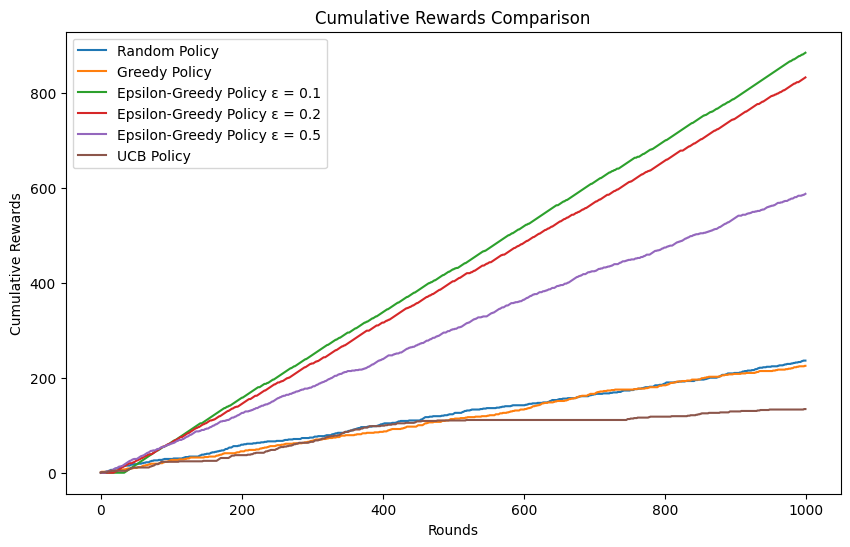

In [22]:
#-----write your code below this line---------
import matplotlib.pyplot as plt

print("Random Policy Average Reward:", random_avg)
print("Greedy Policy Average Reward:", greedy_avg)
print("Epsilon-Greedy Policy Average Reward with ε = 0.1:", epsilon1_avg)
print("Epsilon-Greedy Policy Average Reward with ε = 0.2:", epsilon2_avg)
print("Epsilon-Greedy Policy Average Reward with ε = 0.5:", epsilon5_avg)
print("UCB Policy Average Reward:", ucb_avg)

# Plot cumulative rewards
plt.figure(figsize=(10, 6))
plt.plot(random_cum, label="Random Policy")
plt.plot(greedy_cum, label="Greedy Policy")
plt.plot(epsilon1_cum, label="Epsilon-Greedy Policy ε = 0.1")
plt.plot(epsilon2_cum, label="Epsilon-Greedy Policy ε = 0.2")
plt.plot(epsilon5_cum, label="Epsilon-Greedy Policy ε = 0.5")
plt.plot(ucb_cum, label="UCB Policy")
plt.xlabel("Rounds")
plt.ylabel("Cumulative Rewards")
plt.title("Cumulative Rewards Comparison")
plt.legend()
plt.show()

# Conclusion (0.5M)

Determine which policy performs the best based on cumulative reward. Provide a concise conclusion (250 words) summarizing the decision-making process and the trade-offs between exploration and exploitation.

`----write below this line------`

The best-performing policy is Epsilon-Greedy with ε = 0.1, as it achieves the highest average reward by balancing exploration and exploitation effectively. The trade-off here is that too much exploration (high ε) reduces the reward, while too little exploration (greedy or UCB) leads to suboptimal solutions.